<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_Rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install yfinance --upgrade --no-cache-dir
#!pip install xgboost


In [ ]:
# Análise de dados e manipulação
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# pegar os dados
import yfinance as yf
# Manipulação de datas
from datetime import datetime
from pandas.tseries.offsets import BDay
#extras
import warnings
import logging
from tqdm import tqdm
import yfinance as yf
import pandas as pd
from datetime import datetime
# Verificação de versões (opcional)
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.6.1


In [ ]:
# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignorar warnings desnecessários
warnings.filterwarnings('ignore')

print("Baixando dados...")

# Baixar os dados do Ibovespa
df = yf.download('^BVSP', start='1994-07-01', end=datetime.now().strftime('%Y-%m-%d'))

# Verificar se os dados foram baixados corretamente
if df.empty:
    logging.warning("Falha ao baixar os dados do Ibovespa. Verifique a conexão ou a disponibilidade do Yahoo Finance.")
else:
    logging.info(f"Dados baixados com sucesso! Total de registros: {df.shape[0]}")

# Preencher valores ausentes e garantir que o índice seja datetime
df = df.ffill()
df.index = pd.to_datetime(df.index)


[*********************100%***********************]  1 of 1 completed

Baixando dados...


In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7591 entries, 1994-07-04 to 2025-02-26
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^BVSP)   7591 non-null   float64
 1   (High, ^BVSP)    7591 non-null   float64
 2   (Low, ^BVSP)     7591 non-null   float64
 3   (Open, ^BVSP)    7591 non-null   float64
 4   (Volume, ^BVSP)  7591 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 355.8 KB


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

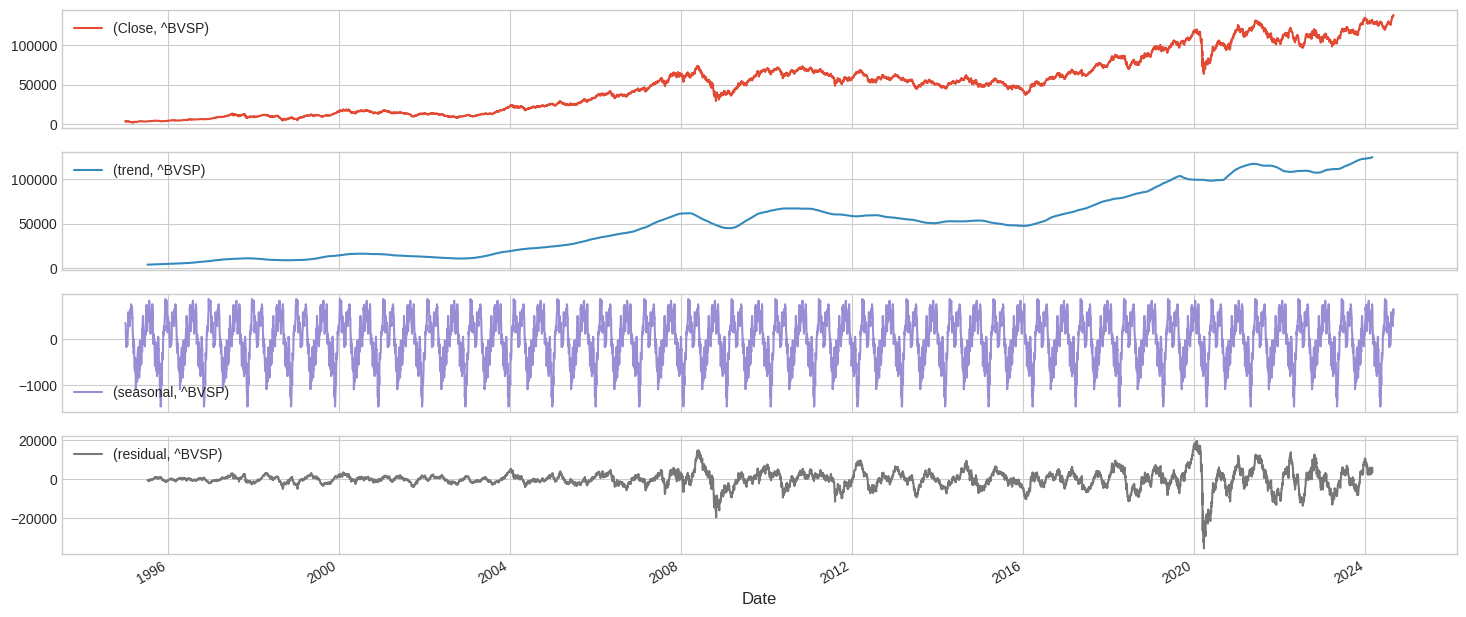

In [670]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Selecionando a série correta
serie_temporal = df[('Close', '^BVSP')].dropna()

# Decomposição sazonal
stl = seasonal_decompose(serie_temporal, period=252)  # 252 dias úteis = ~1 ano

# Adicionando os componentes ao DataFrame
df[('trend', '^BVSP')] = stl.trend.shift(1)
df[('seasonal', '^BVSP')] = stl.seasonal.shift(1)
df[('residual', '^BVSP')] = stl.resid.shift(1)

# Plotando os componentes
df[[('Close', '^BVSP'), ('trend', '^BVSP'), ('seasonal', '^BVSP'), ('residual', '^BVSP')]].plot(subplots=True, figsize=(18, 8))


In [ ]:
# 🔹 Criar Features
def create_features(df):
    for i in range(1, 6):
        df[f'Lag{i}'] = df['Close'].shift(i)
    df['Daily_Return'] = df['Close'].pct_change()
    df['MA_7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['MA_30'] = df['Close'].rolling(window=30, min_periods=1).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=7, min_periods=1).std()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['BB_Mid'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std().squeeze()
    df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
    df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.dropna(inplace=True)
    return df

In [ ]:
# 🔹 Carregar dados e criar features
df = create_features(df)

# 🔹 Separação treino/teste baseada no tempo
cutoff_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

# 🔹 Definir X e y
X = df.drop(columns=['Close'])
y = df['Close']
X_train, X_test = X.loc[train.index], X.loc[test.index]
y_train, y_test = y.loc[train.index], y.loc[test.index]

# 🔹 Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Treinar modelo (Exemplo com RandomForest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 🔹 Criar datas futuras (próximos 5 dias úteis)
future_dates = [df.index[-1] + BDay(i) for i in range(1, 6)]

# 🔹 Pegar features usadas no treinamento
selected_features = X_train.columns.tolist()

# 🔹 Criar dataframe para previsão futura
future_features = pd.DataFrame(np.tile(df[selected_features].iloc[-1].values, (5, 1)),
                               columns=selected_features, index=future_dates)

# 🔹 Aplicar normalização aos dados futuros
future_features_scaled = scaler.transform(future_features)

# 🔹 Fazer previsão
future_predictions = model.predict(future_features_scaled)

# 🔹 Ajustar previsões com pequena variação aleatória
future_predictions_adjusted = [
    pred * (1 + np.random.normal(scale=0.02)) for pred in future_predictions
]

# 🔹 Exibir previsões corrigidas
print("Previsões corrigidas para os próximos 5 dias:")
for i, pred in enumerate(future_predictions_adjusted, 1):
    print(f'Dia {i}: {pred:.2f}')



Previsões corrigidas para os próximos 5 dias:
Dia 1: 126225.26
Dia 2: 124638.02
Dia 3: 126602.65
Dia 4: 128790.72
Dia 5: 124398.33


In [ ]:
last_close = float(df['Close'].iloc[-1].values[0])  # Pegando o primeiro valor da Series
df['Close'] = df['Close'].astype(float)  # Converte valores para float


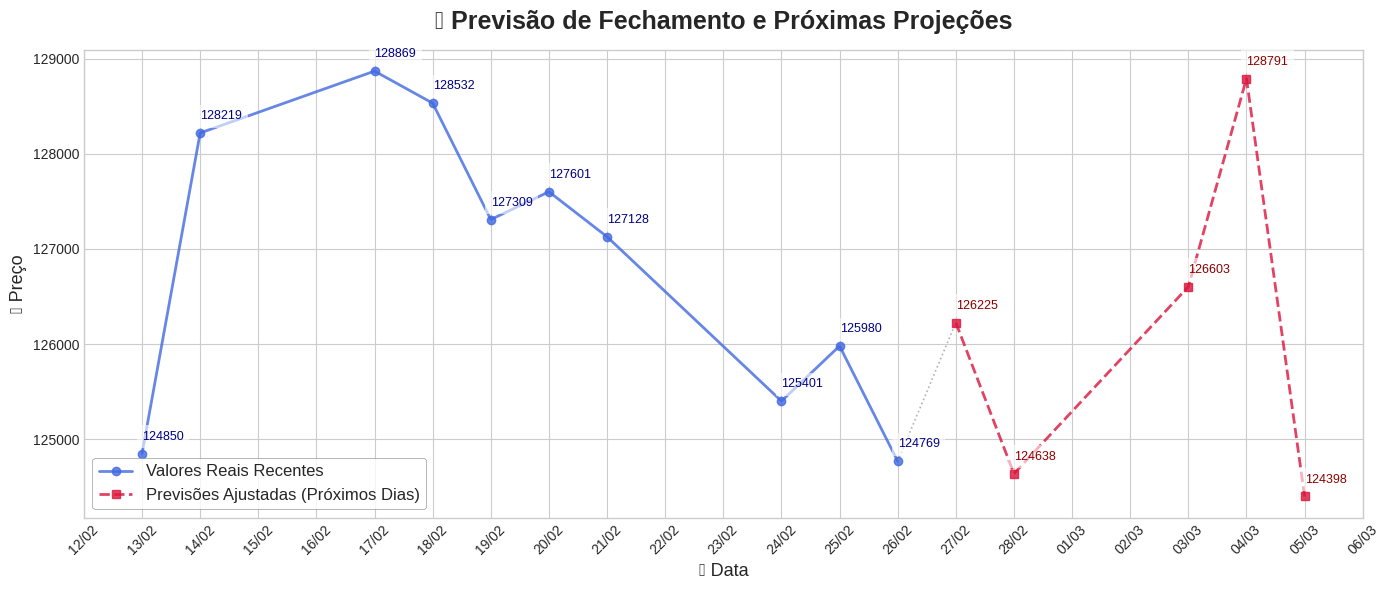

In [ ]:

# 🔹 Configurando o estilo do gráfico
plt.style.use('seaborn-v0_8-whitegrid')

# 🔹 Criando o gráfico
fig, ax1 = plt.subplots(figsize=(14, 6))

# 🔹 Linha azul dos valores reais
ax1.plot(df.index[-10:], df['Close'][-10:], label='Valores Reais Recentes',
         color='royalblue', marker='o', linewidth=2, alpha=0.8)

# 🔹 Ligação entre último valor real e primeiro previsto
ax1.plot([df.index[-1], future_features.index[0]],
         [last_close, float(future_predictions_adjusted[0])],
         color='gray', linestyle='dotted', linewidth=1.2, alpha=0.6)



# 🔹 Linha vermelha das previsões ajustadas
ax1.plot(future_features.index, future_predictions_adjusted,
         label='Previsões Ajustadas (Próximos Dias)',
         color='crimson', linestyle='--', marker='s', linewidth=2, alpha=0.8)

# 🔹 Anotação dos valores com fundo branco para melhor legibilidade
df[('Close', '^BVSP')] = pd.to_numeric(df[('Close', '^BVSP')], errors='coerce')
df = df.dropna(subset=[('Close', '^BVSP')])  # Remove linhas com NaN


for date, value in zip(df.index[-10:], df[('Close', '^BVSP')].iloc[-10:]):
    ax1.annotate(f'{value:.0f}', xy=(date, value), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='navy',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))




for date, prediction in zip(future_features.index, future_predictions_adjusted):
    ax1.annotate(f'{prediction:.0f}', xy=(date, prediction), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='darkred',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# 🔹 Melhorando o formato do eixo X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.tick_params(axis='x', rotation=45)

# 🔹 Melhorando a legenda
ax1.legend(fontsize=12, loc='best', frameon=True, edgecolor='gray')

# 🔹 Melhorando título e rótulos
ax1.set_title('📊 Previsão de Fechamento e Próximas Projeções', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('📅 Data', fontsize=13)
ax1.set_ylabel('💲 Preço', fontsize=13)

# 🔹 Ajustando o layout para evitar cortes
plt.tight_layout()

# 🔹 Exibindo o gráfico
plt.show()


In [ ]:
df[('Close', '^BVSP')]


,Close
,^BVSP
Date,
1994-07-11,4010.899902
1994-07-12,3919.800049
1994-07-13,3840.899902
1994-07-14,4016.500000
1994-07-15,4079.899902
...,...
2025-02-20,127601.000000
2025-02-21,127128.000000
